<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S6/S6_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization of results

In this notebook we shall visualize the results of our saved runs in Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
!pip install torchsummary
from torchsummary import summary

class Net(nn.Module):
    
    def create_conv2d(self, in_channels, out_channels, kernel_size=(3,3), padding=1, bias=False, bn=True, dropout=0, relu=True):
      l = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
      if bn:
        l.append(nn.BatchNorm2d(out_channels))
      if dropout>0:
        l.append(nn.Dropout(dropout))
      if relu:
        l.append(nn.ReLU())

      return nn.Sequential(*l)

    def __init__(self, name="Model", dropout_value=0):
        super(Net, self).__init__()
        
        self.name = name

        # Input Convolution Block
        self.convblock1 = self.create_conv2d(1, 10, dropout=dropout_value) # input_size = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = self.create_conv2d(10, 10, dropout=dropout_value) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 10, RF = 14

        self.convblock5 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 8, RF = 18

        self.convblock6 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 6, RF = 22

        self.convblock7 = self.create_conv2d(10, 16, dropout=dropout_value, padding=0) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = self.create_conv2d(16, 10, kernel_size=(1,1), padding=0, bn=False, relu=False) # output_size = 1, RF = 26

        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def summary(self, input_size): #input_size=(1, 28, 28)
      summary(self, input_size=input_size)

In [0]:
class Transforms:
  """
  Helper class to create test and train transforms
  """
  def __init__(self, normalize=False, mean=None, stdev=None):
    if normalize and (not mean or not stdev):
      raise ValueError('mean and stdev both are required for normalize transform')
  
    self.normalize=normalize
    self.mean = mean
    self.stdev = stdev

  def test_transforms(self):
    transforms_list = [transforms.ToTensor()]
    if(self.normalize):
      transforms_list.append(transforms.Normalize((self.mean,), (self.stdev,)))
    return transforms.Compose(transforms_list)

  def train_transforms(self, pre_transforms=None):
    if pre_transforms:
      transforms_list = pre_transforms
    else:
      transforms_list = []
    transforms_list.append(transforms.ToTensor())

    if(self.normalize):
      transforms_list.append(transforms.Normalize((self.mean,), (self.stdev,)))
    return transforms.Compose(transforms_list)

trans = Transforms(normalize=True, mean=0.1307, stdev=0.3081)

# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       #  transforms.RandomErasing(),
                                       ])

# Test Phase transformations
test_transforms = trans.test_transforms()


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
class DataLoader:
  """
  Helper class to load test and train data
  """
  def __init__(self, shuffle=True, batch_size=128, seed=1):
    cuda = torch.cuda.is_available()
    
    if cuda:
      torch.cuda.manual_seed(seed)

    # dataloader arguments - something you'll fetch these from cmdprmt
    self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=shuffle, batch_size=batch_size)

  def load(self, data):
    return torch.utils.data.DataLoader(data, **self.dataloader_args)

dataloader = DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [0]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
def show25(images, labels, actual, filename):
  r, c = 5, 5
  figmatrix = plt.figure(figsize=(7, 7))
  gs1 = gridspec.GridSpec(r, c)
  gs1.update(wspace=0.005, hspace=0.05) # set the 
  for i in range(1, r*c+1):
    plt.subplot(gs1[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1], cmap='gray_r')
    plt.text(2, 6, labels[i-1], color="red", fontsize="xx-large")
    plt.text(22, 26, actual[i-1], color="green", fontsize="xx-large")
  plt.savefig(filename)
  plt.show()  

In [0]:
import numpy as np
def GetMisclassifiedImages(model, dataloader, cnt):
  
  # obtain one batch of test images
  dataiter = iter(dataloader)
  c=0
  images = None
  lables = None
  actual = None
  while c<cnt:
    try:
      data, target = dataiter.next()
    except:
      break
    data, target = data.to(model.device), target.to(model.device)
    y_pred = model(data)  # get predictions
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect = pred.ne(target.view_as(pred)).cpu().numpy()
    images = np.append(images, data.cpu().numpy()[incorrect], axis=0) if c>0 else data.cpu().numpy()[incorrect]
    labels = np.append(labels, pred.cpu().numpy()[incorrect], axis=0) if c>0 else pred.cpu().numpy()[incorrect]
    actual = np.append(actual, target.view_as(pred).cpu().numpy()[incorrect], axis=0) if c>0 else target.view_as(pred).cpu().numpy()[incorrect]
    c += incorrect.sum()

  return images, labels, actual

In [0]:
def misclassified(name):
  model.load_state_dict(torch.load(f"/content/drive/My Drive/{name}.pt"))
  top_misclassified, labels, actual = GetMisclassifiedImages(model, test_loader, 25)
  show25(top_misclassified, labels, actual, f"/content/drive/My Drive/{name}_misclassified.png")

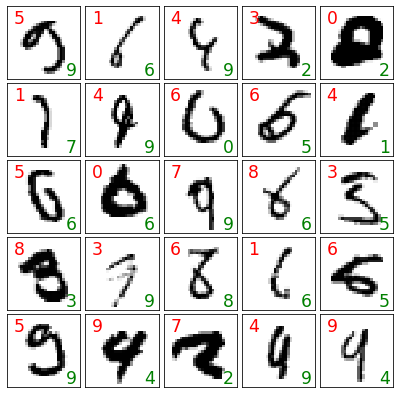

In [97]:
misclassified("s6model_0_0")

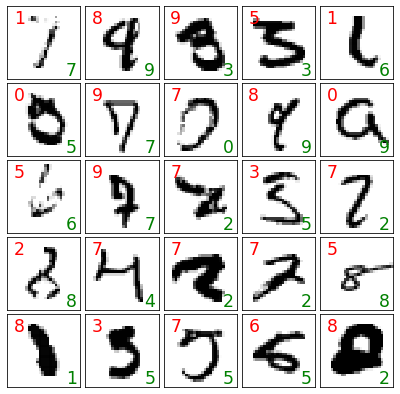

In [98]:
misclassified("s6model_0_1e-06")

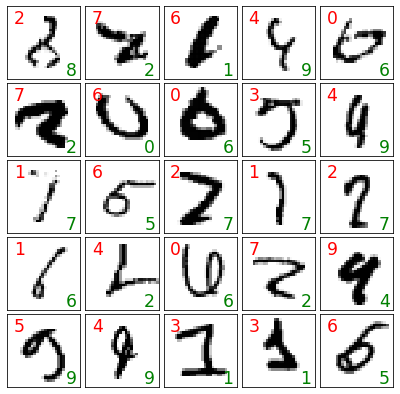

In [99]:
misclassified("s6model_0_5e-05")

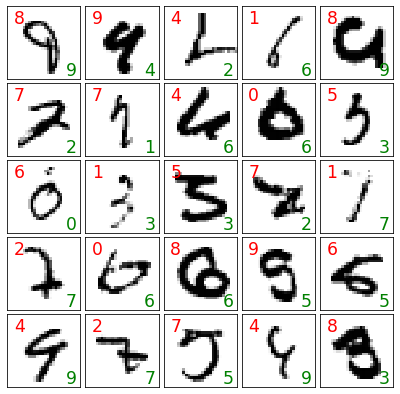

In [106]:
misclassified("s6model_1e-06_1e-06")

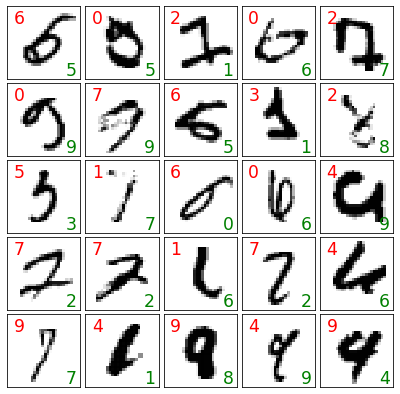

In [107]:
misclassified("s6model_5e-05_5e-05")

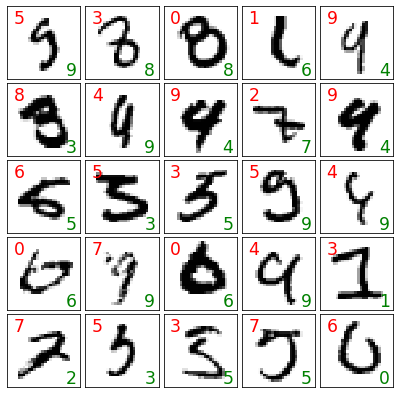

In [108]:
misclassified("s6model_5e-05_0")

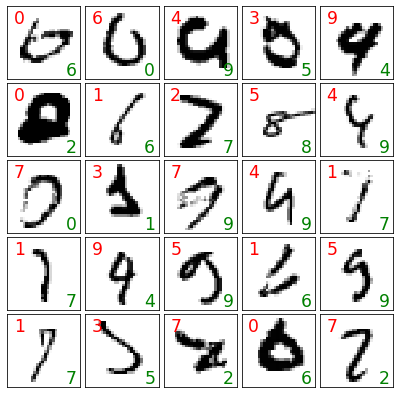

In [121]:
misclassified("s6model_1e-06_0")

In [0]:
import json
with open('/content/drive/My Drive/s6model_0_0_stats.json', 'r') as fp:
    data0 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_1e-06_stats.json', 'r') as fp:
    data1 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_5e-05_stats.json', 'r') as fp:
    data2 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_0.0001_stats.json', 'r') as fp:
    data3 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_0.001_stats.json', 'r') as fp:
    data4 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_0.01_stats.json', 'r') as fp:
    data5 = json.load(fp)

with open('/content/drive/My Drive/s6model_0_0.1_stats.json', 'r') as fp:
    data6 = json.load(fp)

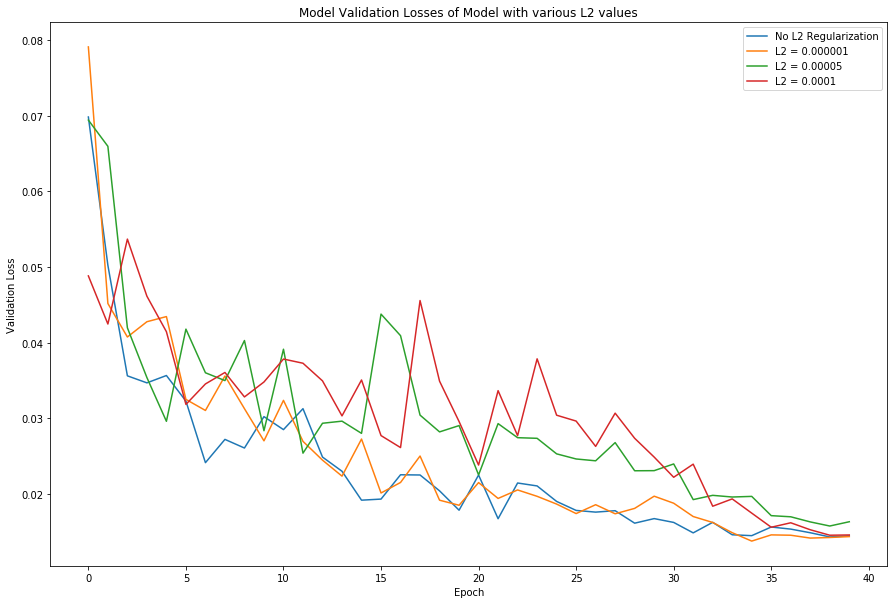

In [113]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
ax.plot(data1['avg_test_loss'])
ax.plot(data2['avg_test_loss'])
ax.plot(data3['avg_test_loss'])
#ax.plot(data4['avg_test_loss'])
#ax.plot(data5['avg_test_loss'])
#ax.plot(data6['avg_test_loss'])
ax.set(title="Model Validation Losses of Model with various L2 values", xlabel="Epoch", ylabel="Validation Loss")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L2 Regularization', 'L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Validation_Loss_L2Variations.png")
plt.show()

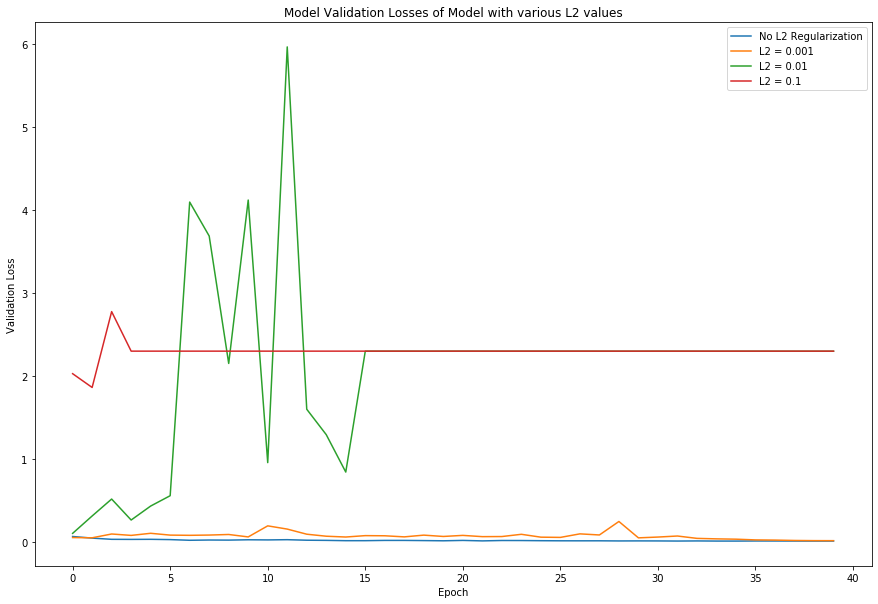

In [111]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
#ax.plot(data1['avg_test_loss'])
#ax.plot(data2['avg_test_loss'])
#ax.plot(data3['avg_test_loss'])
ax.plot(data4['avg_test_loss'])
ax.plot(data5['avg_test_loss'])
ax.plot(data6['avg_test_loss'])
ax.set(title="Model Validation Losses of Model with various L2 values", xlabel="Epoch", ylabel="Validation Loss")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L2 Regularization', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
plt.savefig("/content/drive/My Drive/Bad_Validation_Loss_L2Variations.png")
plt.show()

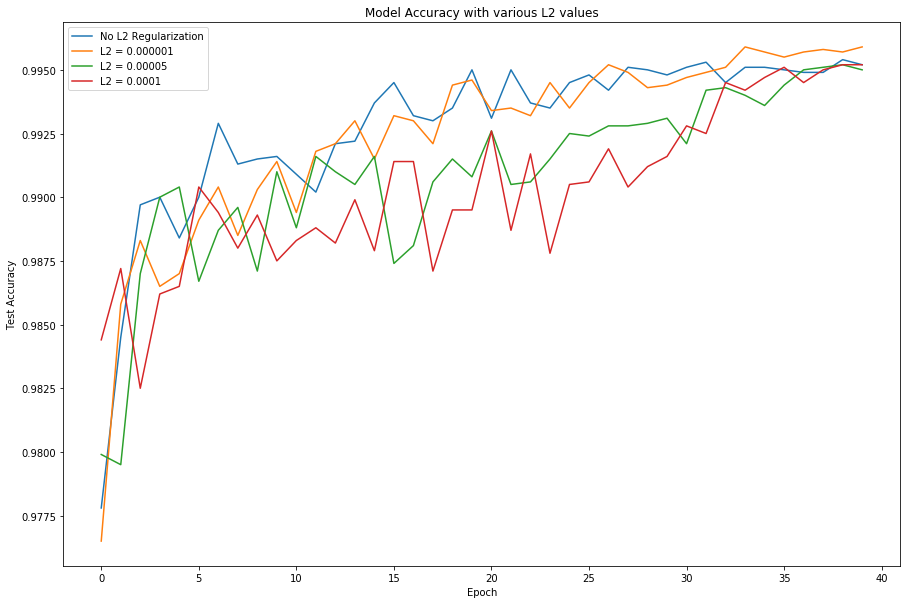

In [91]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['test_acc'])
ax.plot(data1['test_acc'])
ax.plot(data2['test_acc'])
ax.plot(data3['test_acc'])
ax.set(title="Model Accuracy with various L2 values", xlabel="Epoch", ylabel="Test Accuracy")
ax.legend(['No L2 Regularization', 'L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Accuracy_L2Variations.png")
plt.show()

In [0]:
import json
with open('/content/drive/My Drive/s6model_1e-06_0_stats.json', 'r') as fp:
    data7 = json.load(fp)

with open('/content/drive/My Drive/s6model_5e-05_0_stats.json', 'r') as fp:
    data8 = json.load(fp)

with open('/content/drive/My Drive/s6model_0.0001_0_stats.json', 'r') as fp:
    data9 = json.load(fp)

with open('/content/drive/My Drive/s6model_0.001_0_stats.json', 'r') as fp:
    data10 = json.load(fp)

with open('/content/drive/My Drive/s6model_0.01_0_stats.json', 'r') as fp:
    data11 = json.load(fp)

with open('/content/drive/My Drive/s6model_0.1_0_stats.json', 'r') as fp:
    data12 = json.load(fp)

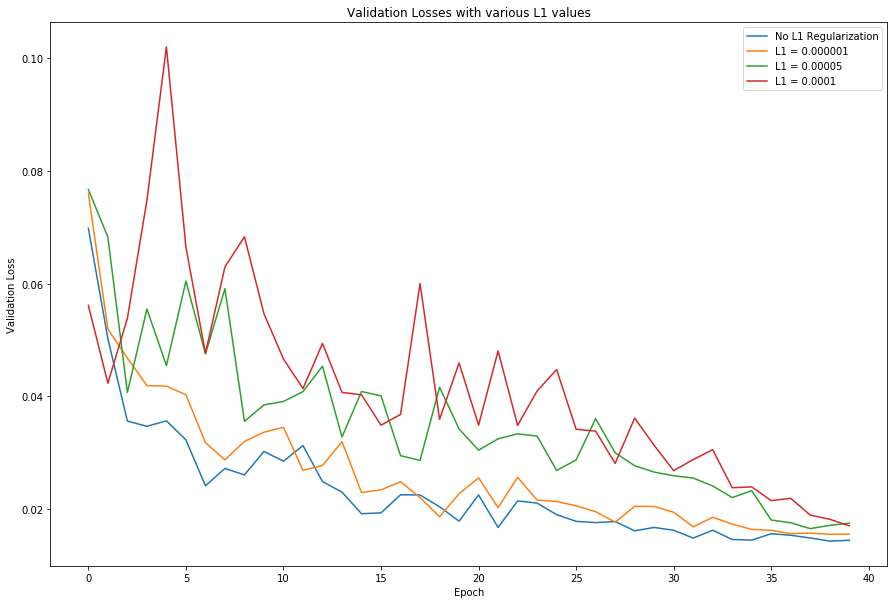

In [116]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
ax.plot(data7['avg_test_loss'])
ax.plot(data8['avg_test_loss'])
ax.plot(data9['avg_test_loss'])
#ax.plot(data10['avg_test_loss'])
#ax.plot(data11['avg_test_loss'])
#ax.plot(data12['avg_test_loss'])
ax.set(title="Validation Losses with various L1 values", xlabel="Epoch", ylabel="Validation Loss")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L1 Regularization', 'L1 = 0.000001', 'L1 = 0.00005', 'L1 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Validation_Loss_L1Variations.png")
plt.show()

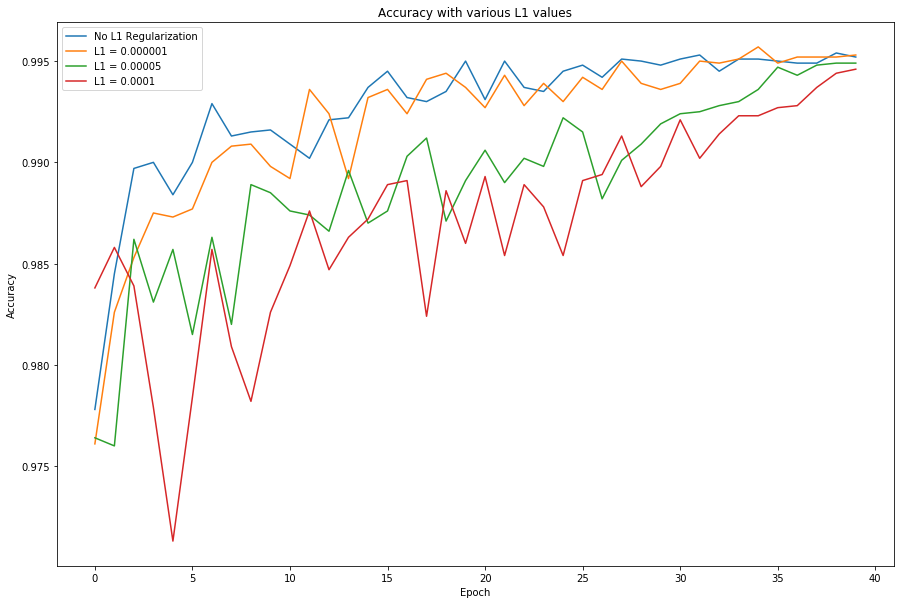

In [117]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['test_acc'])
ax.plot(data7['test_acc'])
ax.plot(data8['test_acc'])
ax.plot(data9['test_acc'])
#ax.plot(data10['avg_test_loss'])
#ax.plot(data11['avg_test_loss'])
#ax.plot(data12['avg_test_loss'])
ax.set(title="Accuracy with various L1 values", xlabel="Epoch", ylabel="Accuracy")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L1 Regularization', 'L1 = 0.000001', 'L1 = 0.00005', 'L1 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Accuracy_L1Variations.png")
plt.show()

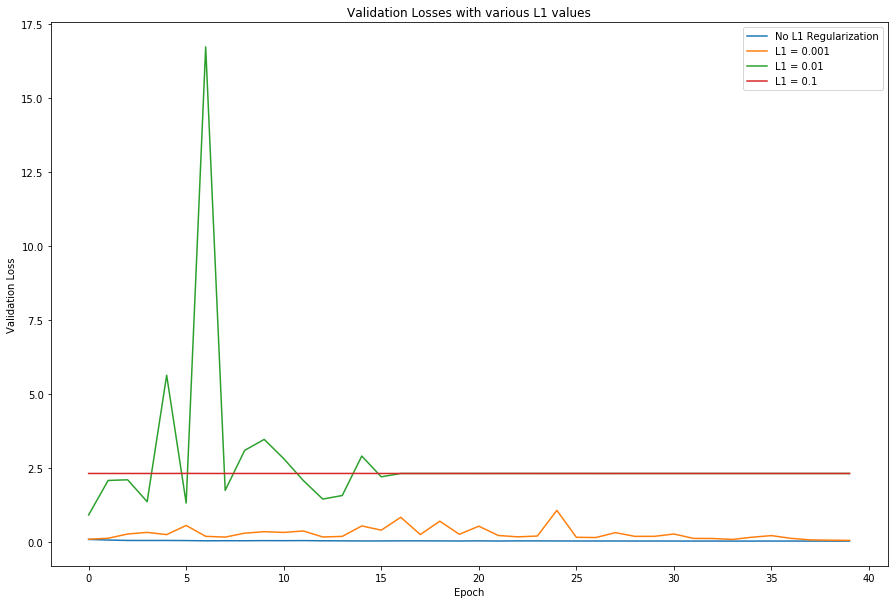

In [118]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
#ax.plot(data7['avg_test_loss'])
#ax.plot(data8['avg_test_loss'])
#ax.plot(data9['avg_test_loss'])
ax.plot(data10['avg_test_loss'])
ax.plot(data11['avg_test_loss'])
ax.plot(data12['avg_test_loss'])
ax.set(title="Validation Losses with various L1 values", xlabel="Epoch", ylabel="Validation Loss")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L1 Regularization', 'L1 = 0.001', 'L1 = 0.01', 'L1 = 0.1'], loc='best')
plt.savefig("/content/drive/My Drive/Bad_Validation_Loss_L1Variations.png")
plt.show()

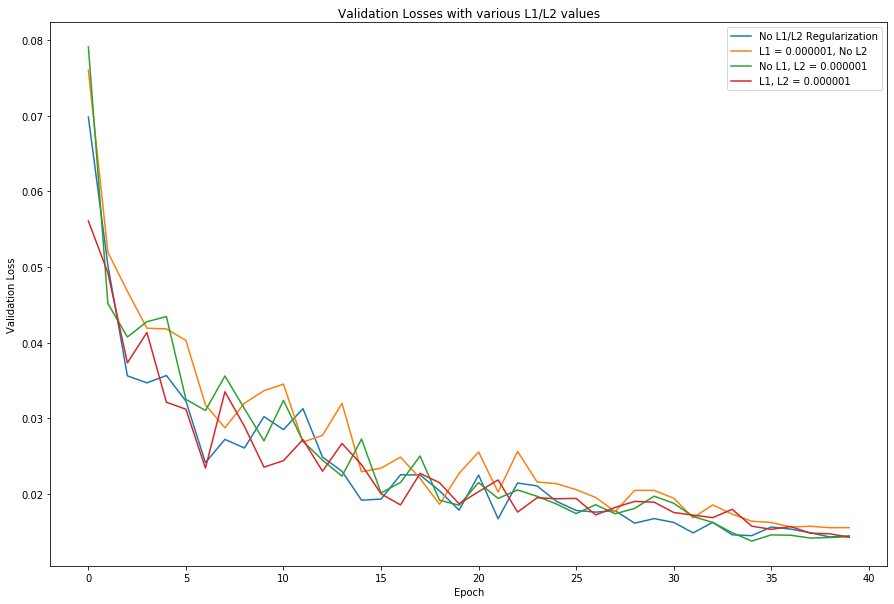

In [119]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
ax.plot(data7['avg_test_loss'])
ax.plot(data1['avg_test_loss'])
ax.plot(data13['avg_test_loss'])
#ax.plot(data10['avg_test_loss'])
#ax.plot(data11['avg_test_loss'])
#ax.plot(data12['avg_test_loss'])
ax.set(title="Validation Losses with various L1/L2 values", xlabel="Epoch", ylabel="Validation Loss")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L1/L2 Regularization', 'L1 = 0.000001, No L2', 'No L1, L2 = 0.000001', 'L1, L2 = 0.000001'], loc='best')
plt.savefig("/content/drive/My Drive/Validation_Loss_L1L2Variations_best.png")
plt.show()

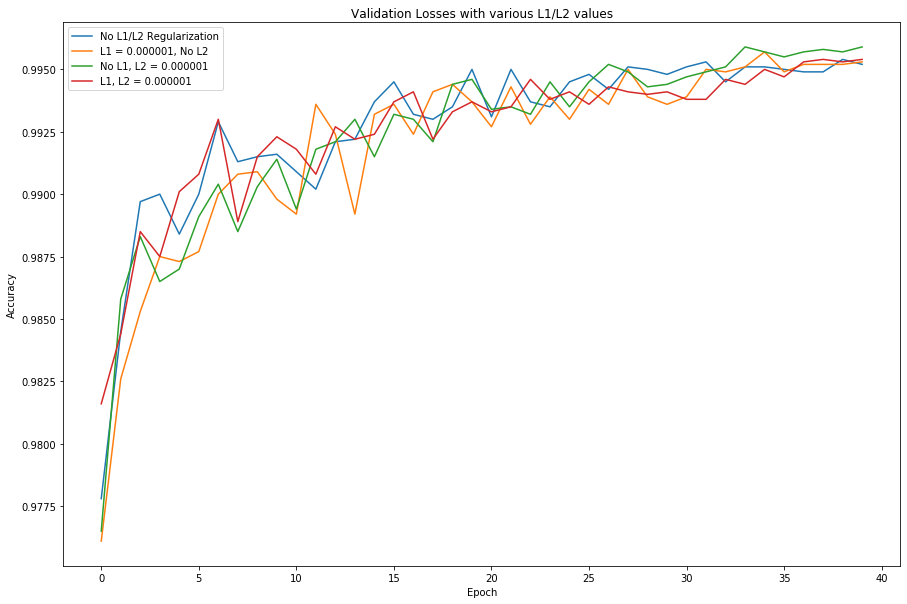

In [120]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['test_acc'])
ax.plot(data7['test_acc'])
ax.plot(data1['test_acc'])
ax.plot(data13['test_acc'])
#ax.plot(data10['avg_test_loss'])
#ax.plot(data11['avg_test_loss'])
#ax.plot(data12['avg_test_loss'])
ax.set(title="Validation Losses with various L1/L2 values", xlabel="Epoch", ylabel="Accuracy")
#ax.legend(['L2 = 0.000001', 'L2 = 0.00005', 'L2 = 0.0001', 'L2 = 0.001', 'L2 = 0.01', 'L2 = 0.1'], loc='best')
ax.legend(['No L1/L2 Regularization', 'L1 = 0.000001, No L2', 'No L1, L2 = 0.000001', 'L1, L2 = 0.000001'], loc='best')
plt.savefig("/content/drive/My Drive/Accuracy_L1L2Variations_best.png")
plt.show()

In [0]:
import json
with open('/content/drive/My Drive/s6model_1e-06_1e-06_stats.json', 'r') as fp:
    data13 = json.load(fp)

with open('/content/drive/My Drive/s6model_5e-05_5e-05_stats.json', 'r') as fp:
    data14 = json.load(fp)

with open('/content/drive/My Drive/s6model_0.0001_0.0001_stats.json', 'r') as fp:
    data15 = json.load(fp)

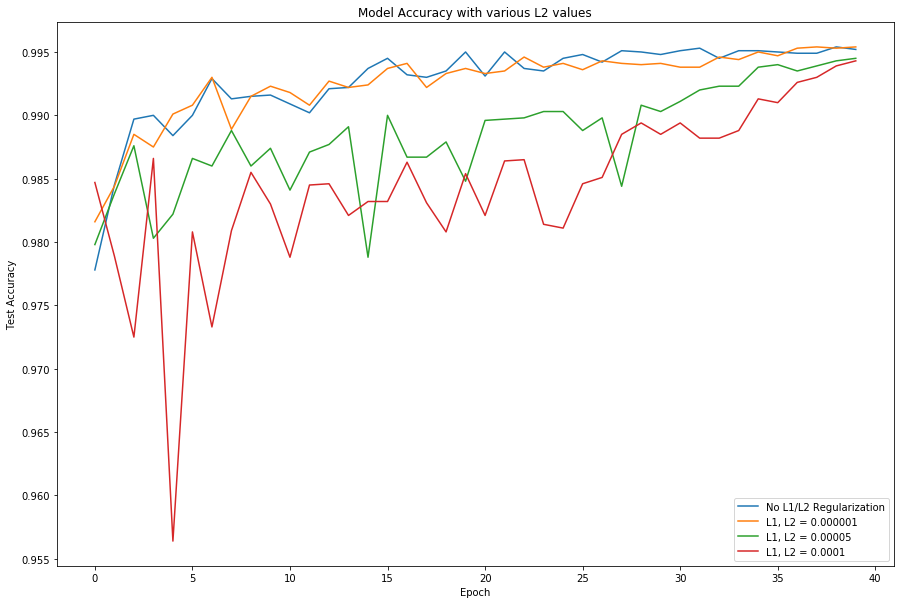

In [103]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['test_acc'])
ax.plot(data13['test_acc'])
ax.plot(data14['test_acc'])
ax.plot(data15['test_acc'])
ax.set(title="Model Accuracy with various L2 values", xlabel="Epoch", ylabel="Test Accuracy")
ax.legend(['No L1/L2 Regularization', 'L1, L2 = 0.000001', 'L1, L2 = 0.00005', 'L1, L2 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Accuracy_L1L2Variations.png")
plt.show()

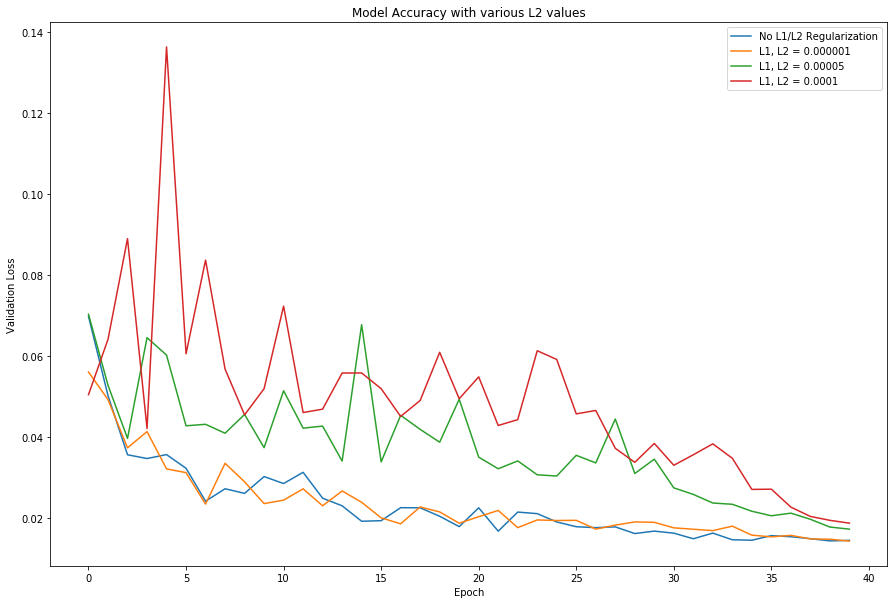

In [105]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(data0['avg_test_loss'])
ax.plot(data13['avg_test_loss'])
ax.plot(data14['avg_test_loss'])
ax.plot(data15['avg_test_loss'])
ax.set(title="Model Accuracy with various L2 values", xlabel="Epoch", ylabel="Validation Loss")
ax.legend(['No L1/L2 Regularization', 'L1, L2 = 0.000001', 'L1, L2 = 0.00005', 'L1, L2 = 0.0001'], loc='best')
plt.savefig("/content/drive/My Drive/Validation_Loss_L1L2Variations.png")
plt.show()